# House Detector

In [1]:
# !pip install tensorflow
!pip install -U -q PyDrive
!pip install "tensorflow_hub>=0.6.0"

import tensorflow as tf
from google.colab import drive
tf.__version__

drive.flush_and_unmount()

!rm -rf ./data
!rm -rf ./*

Drive not mounted, so nothing to flush and unmount.


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!wget https://github.com/thejawker/architector/raw/master/data/house_vs_no_house.zip -P /content/data

--2020-04-24 19:45:32--  https://github.com/thejawker/architector/raw/master/data/house_vs_no_house.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thejawker/architector/master/data/house_vs_no_house.zip [following]
--2020-04-24 19:45:32--  https://raw.githubusercontent.com/thejawker/architector/master/data/house_vs_no_house.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41373417 (39M) [application/zip]
Saving to: ‘/content/data/house_vs_no_house.zip’

house_vs_no_house.z 100%[===================>]  39.46M   176MB/s    in 0.2s    

2020-04-24 19:45:33 (176 MB/s) - ‘/content/data/house_vs

In [4]:
# Get files ready
from os import getcwd
import os
import zipfile
from shutil import copyfile

data_dir = f"{getcwd()}/data"
tmp_dir = f"{data_dir}/tmp"
houses_dir = f"{data_dir}/house_vs_no_house.zip"
checkpoint_path = f"{getcwd()}/drive/My Drive/Colab Notebooks/model_checkpoints"


# delete tmp
!rm -rf ./data/tmp

print(houses_dir)
with zipfile.ZipFile(houses_dir, 'r') as zip_obj:
  zip_obj.extractall(f"{tmp_dir}/raw/")

/content/data/house_vs_no_house.zip


In [5]:
try:
    dirs_to_make = [
        'training/house',
        'training/no_house',
        'testing/house',
        'testing/no_house',
    ]
    
    for dir in dirs_to_make:
        os.makedirs(os.path.join(tmp_dir, dir))
      
    # make checkpoints dir
    os.makedirs(checkpoint_path)
except OSError as err:
  print('something went wrong')
  print(err)
  pass


limit = 1100
split = .9

for type in ['house', 'no_house']:
    img_dir = f"{tmp_dir}/raw/house_vs_no_house"
    data = os.listdir(os.path.join(img_dir, type))
    data = data[:limit]
    print(f'{type} contains: {len(data)} images')
    split_at = int(len(data) * split)
    data_set = {
        'training': data[:split_at],
        'testing': data[split_at:]
    }
    
    for (dir_name, photos) in data_set.items():
        for photo in photos:            
            try:
                source = f"{img_dir}/{type}/{photo}"
                dest = f"{tmp_dir}/{dir_name}/{type}/{photo}"
                copyfile(source, dest)
            except:
                print('cant copy')
                pass

something went wrong
[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/model_checkpoints'
house contains: 1100 images
no_house contains: 1100 images


In [10]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4",
              trainable=False, arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Dense(2, activation='softmax'),
])
model.build([None, 299, 299, 3])

if len(os.listdir(checkpoint_path)) > 0:
  print('Loading from checkpoint')
  model.load_weights(checkpoint_path)
else:
  print('Creating new sequential')

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Loading from checkpoint


OSError: ignored

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 25

TRAINING_DIR = f"{tmp_dir}/training"
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(299, 299))

VALIDATION_DIR = f"{tmp_dir}/testing"
validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical', 
                                                              target_size=(299, 299))

Found 1911 images belonging to 2 classes.
Found 213 images belonging to 2 classes.


In [37]:
STEP_SIZE_TRAIN = (train_generator.n//train_generator.batch_size)
STEP_SIZE_VALID = (validation_generator.n//validation_generator.batch_size)

min_val = 0.98

class StopOnComplete(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('acc') > min_val):
            print(f"Reached {min_val}% accuracy so cancelling training!")
            self.model.stop_training = True

checkpoint_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

callbacks = [StopOnComplete(), checkpoint_save]

history = model.fit(train_generator,
                    epochs=60,
                    verbose=1,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    validation_data=validation_generator,
                    shuffle=True,
                    callbacks=callbacks)


Epoch 1/60
76/76 [==============================] - ETA: 0s - loss: 0.2856 - acc: 0.9000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 668ms/step - loss: 0.2856 - acc: 0.9000 - val_loss: 0.2634 - val_acc: 0.9250
Epoch 2/60
76/76 [==============================] - ETA: 0s - loss: 0.2057 - acc: 0.9369INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 673ms/step - loss: 0.2057 - acc: 0.9369 - val_loss: 0.2876 - val_acc: 0.9300
Epoch 3/60
76/76 [==============================] - ETA: 0s - loss: 0.1934 - acc: 0.9369INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 667ms/step - loss: 0.1934 - acc: 0.9369 - val_loss: 0.2950 - val_acc: 0.9350
Epoch 4/60
76/76 [==============================] - ETA: 0s - loss: 0.1738 - acc: 0.9417INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 668ms/step - loss: 0.1738 - acc: 0.9417 - val_loss: 0.2498 - val_acc: 0.9450
Epoch 5/60
76/76 [==============================] - ETA: 0s - loss: 0.1738 - acc: 0.9422INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 667ms/step - loss: 0.1738 - acc: 0.9422 - val_loss: 0.2412 - val_acc: 0.9350
Epoch 6/60
76/76 [==============================] - ETA: 0s - loss: 0.1732 - acc: 0.9406INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 50s 659ms/step - loss: 0.1732 - acc: 0.9406 - val_loss: 0.2682 - val_acc: 0.9300
Epoch 7/60
76/76 [==============================] - ETA: 0s - loss: 0.1552 - acc: 0.9517Reached 0.95% accuracy so cancelling training!
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model_checkpoints/assets


76/76 [==============================] - 51s 666ms/step - loss: 0.1552 - acc: 0.9517 - val_loss: 0.2459 - val_acc: 0.9350


Text(0.5, 1.0, 'Training and validation loss')

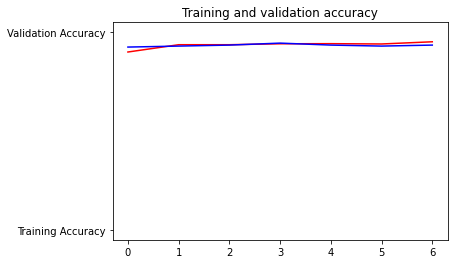

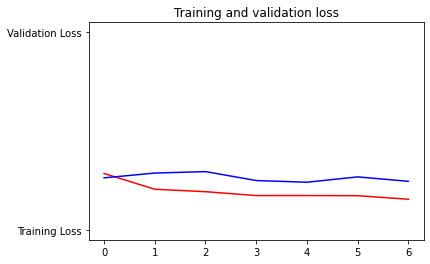

In [38]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [39]:
from keras.preprocessing import image
import numpy as np
from google.colab import files

uploaded = files.upload()

for name in uploaded.keys():
  # print(image_location)
    # if '.DS_Store' in image_location:
    #     continue
    path = os.path.join(getcwd(), name)
        
    # path = f'{data_dir}/testers/{image_location}'
    img = image.load_img(path, target_size=(299, 299))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255
    images = np.vstack([x])

    classes = model.predict(images, batch_size=30)

    print(classes[0])

    if classes[0][0]>.9:
        print(f"{name} is a house")
    else:
        print(f"{name} is NOT a house")

Using TensorFlow backend.


Saving beach.jpg to beach.jpg
Saving cat_grass.jpg to cat_grass.jpg
Saving cat.jpeg to cat.jpeg
Saving computer.jpg to computer.jpg
Saving cool_house.jpeg to cool_house.jpeg
Saving drawing_house.jpg to drawing_house.jpg
Saving empty-box-in-a-field-of-grass-AC66D6.jpg to empty-box-in-a-field-of-grass-AC66D6.jpg
Saving green-color-interior-design-980x653.jpg to green-color-interior-design-980x653.jpg
Saving horse.jpg to horse.jpg
Saving house1.jpg to house1.jpg
Saving interior_design.jpeg to interior_design.jpeg
[0.9760903  0.02390974]
beach.jpg is a house
[0.43890452 0.56109554]
cat_grass.jpg is NOT a house
[0.15775165 0.8422483 ]
cat.jpeg is NOT a house
[0.0088379  0.99116206]
computer.jpg is NOT a house
[0.97614074 0.02385924]
cool_house.jpeg is a house
[0.36949933 0.6305006 ]
drawing_house.jpg is NOT a house
[0.85855925 0.14144072]
empty-box-in-a-field-of-grass-AC66D6.jpg is NOT a house
[0.04237998 0.95762   ]
green-color-interior-design-980x653.jpg is NOT a house
[0.6360745  0.36392

In [62]:
model.save('drive/path_to_my_model')
# !zip path_to_my_model.mod

UnimplementedError: ignored